# Pill Identifier Machine Learning Model and API
All pills and tablets have a unique combination of features that allow them to be identified. 
These features are its color, its shape, and imprints made in front and/or at the back of the drug.

This model will utilize [insert model here] for image classification.

[more details to be added]

# Imports, Declarations, and Globals

In [18]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt     # to plot charts
import numpy as np
import numba as nb                  # to optimize any mathematics
import pickle as pkl                # to save our model
import cv2                          # to filter image artifacts
import sklearn                      # for dataset splitting and metrics

# sklearn imports for metrics and dataset splitting
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# keras imports for image preprocessing
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.utils import to_categorical

# keras imports for model building 

# keras imports for early stoppage and model checkpointing
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from enum import Enum

# may no longer be needed depending on how we build the model
class Colors(Enum):
  White = "FFFFFF"
  Offwhite = "F4F4F4"
  Clear = ""
  Gray = "808080"
  Black = "000000"
  Tan = "D2B48D"
  Brown = "996633"
  Red = "FF0000"
  Orange = "FF8000"
  Peach = "FFDAB9"
  Yellow = "F0F00A"
  Gold = "FFD700"
  Green = "0AEE08"
  Turquoise = "09FEDD"
  Blue = "3768F6"
  Purple = "730996"
  Pink = "FF69B4"
  Multicolor = ""

# Helper Functions

# Data Acquisition

In [19]:
directory = "dataset"
img_height = 120
img_width = 120
batch_size=32

# training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels=None,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 8784 files belonging to 1 classes.


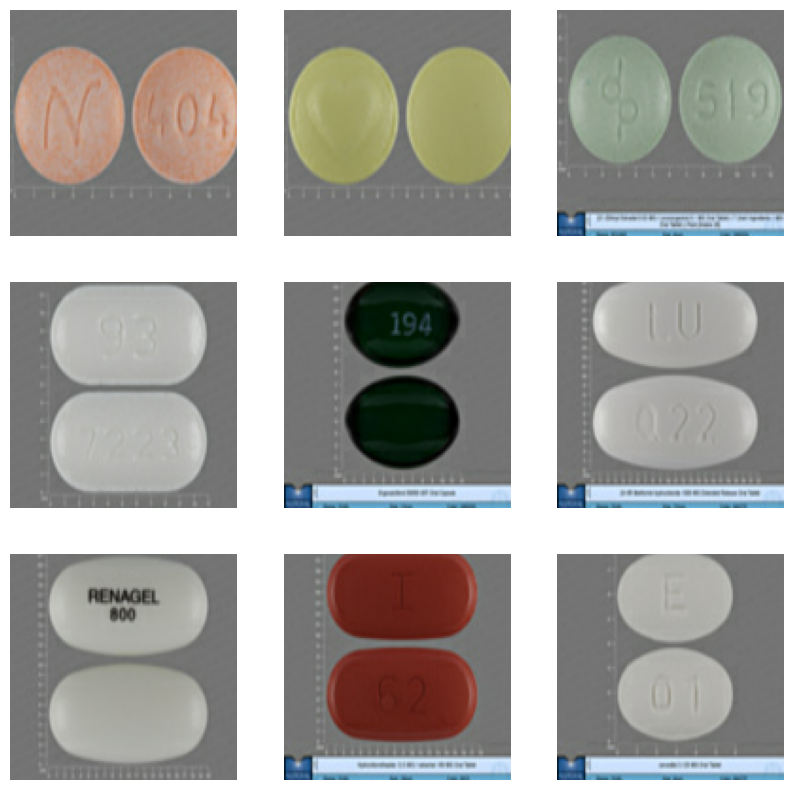

In [20]:
# visualization of the irst 9 images of the dataset
plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
for images in train_ds.take(1):
  for i in range(9):
#     ax = plt.pyplot.subplot(3, 3, i + 1)
#     plt.pyplot.imshow(images[i].numpy().astype("uint8"))
#     plt.pyplot.axis("off")
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# Preprocessing

In [ ]:
#Splitting dataset into 80/20
training_dataframe, testing_dataframe = train_test_split(df, test_size = 0.2, random_state = 42)


# Filtering
Using OpenCV, filter out any artifacts (i.e. background, lens flares, graininess, etc.) and extract the features necessary for identification.

In [ ]:
# apply thresholding to a color image
def thresholding(img):
  # Split the image into the B,G,R components
  b, g, r = cv2.split(img)

  # Apply thresholding to each channel
  _, b = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  _, g = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  _, r = cv2.threshold(r, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Merge the channels
  thresholded = cv2.merge([b, g, r])

  return thresholded

def identifyFeatures (img):
  # function here

# Hyperparameter Search and/or Parameter Setting


# Model Training

# Model Testing

# Save the Model

# Predict